In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint

In [2]:
# 限制 GPU 使用大小（keras版）
gpu_option = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_option))
tf.keras.backend.set_session(sess)

In [3]:
cifar_dir = "./dataset/cifar10/"

In [4]:
print('tensorflow ver.: ' + tf.__version__)
print('keras ver.     : ' + keras.__version__)

tensorflow ver.: 1.13.0-rc1
keras ver.     : 2.2.4-tf


### 資料下載與另存（首次需要執行）

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
cifar10_name = ['airplain', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# training data 落地
for i, item in enumerate(cifar10_name):
    image = x_train[np.where(y_train.squeeze() == i)]
    j = 0
    for im in image:
        cv2.imwrite(cifar_dir + 'train/' + item + '/' + str(j) + '.jpg', 
                    im[:,:,(2,1,0)])
        j += 1

In [ ]:
# validation data 落地
for i, item in enumerate(cifar10_name):
    image = x_test[np.where(y_test.squeeze() == i)]
    j = 0
    for im in image:
        cv2.imwrite(cifar_dir + 'validtion/' + item + '/' + str(j) + '.jpg', 
                    im[:,:,(2,1,0)])
        j += 1

### 資料預處理

In [5]:
# Z-score
# 一個 model 直接 fine tune val_acc 會非常差
# 但有先只訓練 fc 在 fine tune 的話，效果不會差太多
def zscore_preprocess(data):
    data = data.astype('float32')
    _COLOR_MEAN = [125.307, 122.950, 113.865]
    _COLOR_STD = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        data[...,i] = (data[...,i]-_COLOR_MEAN[i]) / _COLOR_STD[i]
    return data

In [6]:
# imageNet diff mean
def color_preprocess(data):
    data = data.astype('float32')
    _COLOR_MEAN = [123.68, 116.779, 103.939]
    data -=  _COLOR_MEAN
    
    return data

In [5]:
IMAGE_SIZE = 224
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=25,           # 隨機旋轉度數範圍
    shear_range=0.2,             # 剪切強度
    horizontal_flip=True,        # 隨機水平翻轉 
    width_shift_range=0.15,     # 水平平移
    height_shift_range=0.15,    # 垂直平移
    fill_mode='constant',         # 填充方式
    cval=0,                      # 補值=0 
    # 使用 keras resnet50 自建的 data preprocess 
    preprocessing_function=resnet50.preprocess_input
)
train_generator = train_datagen.flow_from_directory(
    cifar_dir + 'train', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(
    #preprocessing_function=color_preprocess
    preprocessing_function=resnet50.preprocess_input
)
validation_generator = validation_datagen.flow_from_directory(
    cifar_dir + 'validation', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
    class_mode='categorical'
)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


### Transfer Learning

In [7]:
# 對於 fc 層嘗試使用 gelu 作為 activation function
def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

如果在 transfer learning 使用 `Sequential()` 建立模型，並在添加自定義的全連接層，在後面要進行 heatmaps of activation 時會遇到執行`K.gradients()` 卻返回 None 的問題。因此需要使用 `Model()` function API 來建構模型。  
以下為使用 `Sequential()` 建立模型的方法：
```python
base_model.trainable = False
norm_l2 = keras.regularizers.l2(0.00001)
main_model = keras.Sequential([
    base_model,
    keras.layers.Dense(2048, activation=gelu, 
                       kernel_initializer='he_normal',
                       kernel_regularizer=norm_l2,
                       name='custom_fc_1'),
    keras.layers.Dropout(0.5,),
    keras.layers.Dense(256, activation=gelu, 
                         kernel_initializer='he_normal',
                         kernel_regularizer=norm_l2,
                         name='custom_fc_2'),
    keras.layers.Dense(10, activation='softmax', name='custom_logits')
])    
```

此外，當 model 有使用到 BN 層時，transfer learning 會有問題，詳細可以參考這個[網站](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)。  
主要概念是講述 keras 通常是使用 `trainable` 來控制某一層的權重是否可以更新。
BN 有一參數 `training` 是用來控制標準化時，使用當前 batch 的平均數和標準差（training 模式）還是使用移動平均和移動標準差（測試模式）。這個參數由 keras K.learning_phase 來控制，單純使用 `trainabel` 是不會影響 BN 的 `training` 參數。  
所以當我們使用 transfer learning 來訓練模型時，BN 層會使用目標數據當前 batch 的平均數和標準差進行標準化，但對預測時則會使用源數據的移動平均、標準差來進行標準化。然而在訓練時，BN 層前後期望得到和源數據類似的標準化縮放（但訓練時是使用目標數據的 batch 資料來標準化），再加上 freezed 住參數，導致影響最後全連接層參數的學習。在測試時又使用源數據的移動平均來標準化。這才導致測試集的準確率大幅低於訓練集的準確率。
我們這邊採用讓訓練時的 BN 層也使用源資料的移動平均、標準差來標準化。[來源](https://github.com/keras-team/keras/pull/996)

In [8]:
# 先將 pre train model 的 BN 層給 freezed 住（使用 set_learning phase）
K.set_learning_phase(0)
base_model = resnet50.ResNet50(
    include_top=False,
    weights='imagenet',  
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling='avg',
)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# 使用 model 來新增層數，而不是用 sequential 來新增。
norm_l2 = keras.regularizers.l2(0.0001)
# freezed
base_model_output = base_model.output


K.set_learning_phase(1)
net = Dense(2048, activation=gelu, kernel_initializer='he_normal',
            kernel_regularizer=norm_l2, name='custom_fc_1')(base_model_output)
net = Dropout(0.5,)(net)
net = Dense(256, activation=gelu, kernel_initializer='he_normal',
            kernel_regularizer=norm_l2, name='custom_fc_2')(net)
logits = Dense(10, activation='softmax', name='custom_logits')(net)

main_model = keras.models.Model(inputs=base_model.input, outputs=logits)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
# 先訓練全連接層，防止隨機初始化的參數有較大的梯度把 pre train model 的參數給破壞掉。
set_trainable = False
for layer in main_model.layers:
    if layer.name == 'custom_fc_1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
main_model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
                   loss=tf.keras.losses.categorical_crossentropy,
                   metrics=['accuracy'])

In [14]:
main_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
# 只有 6 種參數能進行訓練
len(main_model.trainable_weights)

6

In [16]:
epoch = 6
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [17]:
history = main_model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epoch, 
    validation_data=validation_generator, 
    validation_steps=validation_steps,
    workers=4,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
1563/1563 [==============================] - 201s 128ms/step - loss: 1.6542 - acc: 0.5335 - val_loss: 1.3306 - val_acc: 0.6396
Epoch 2/6
1563/1563 [==============================] - 197s 126ms/step - loss: 1.2923 - acc: 0.6180 - val_loss: 1.2019 - val_acc: 0.6601
Epoch 3/6
1563/1563 [==============================] - 197s 126ms/step - loss: 1.1962 - acc: 0.6374 - val_loss: 1.0819 - val_acc: 0.6775
Epoch 4/6
1563/1563 [==============================] - 196s 126ms/step - loss: 1.1400 - acc: 0.6489 - val_loss: 1.1473 - val_acc: 0.6679
Epoch 5/6
1563/1563 [==============================] - 196s 126ms/step - loss: 1.1054 - acc: 0.6562 - val_loss: 1.0615 - val_acc: 0.6829
Epoch 6/6
1563/1563 [==============================] - 195s 125ms/step - loss: 1.0872 - acc: 0.6650 - val_loss: 1.0838 - val_acc: 0.6783


### Fine Tune

In [18]:
main_model.trainable = True

In [19]:
# 以 block5 後來進行 fine tune，‘res5a_branch2a‘是 block5 的第一層
set_trainable = False
for layer in main_model.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
# 確認 fine tune 數量改變
len(main_model.trainable_weights)

46

In [21]:
main_model.compile(optimizer=keras.optimizers.Adam(lr=0.00002),
                   loss=tf.keras.losses.categorical_crossentropy,
                   metrics=['accuracy'])

In [22]:
main_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
# 第一次 epoch 使用 5-e4 的學習速率，後面的都使用 1-e4 的學習速率
def scheduler(epoch):
    if epoch == 7:
        return 5e-4
    else:
        return 1e-4

In [24]:
cbks = [TensorBoard(log_dir='./keras_model/log/resnet', histogram_freq=0),
        LearningRateScheduler(scheduler),
        ModelCheckpoint('./keras_model/resnet_finetune.h5',
                        monitor='val_acc', save_best_only=True)]
epoch_fine_tune = 12 + epoch

In [25]:
history_finetune = main_model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epoch_fine_tune, 
    validation_data=validation_generator, 
    validation_steps=validation_steps,
    workers=4,
    initial_epoch=epoch,
    callbacks=cbks,
)

Epoch 7/18
1563/1563 [==============================] - 216s 138ms/step - loss: 0.9252 - acc: 0.7199 - val_loss: 0.7680 - val_acc: 0.7813
Epoch 8/18
1563/1563 [==============================] - 206s 132ms/step - loss: 0.8783 - acc: 0.7325 - val_loss: 0.7200 - val_acc: 0.7810
Epoch 9/18
1563/1563 [==============================] - 207s 132ms/step - loss: 0.5572 - acc: 0.8353 - val_loss: 0.5501 - val_acc: 0.8417
Epoch 10/18
1563/1563 [==============================] - 205s 131ms/step - loss: 0.4991 - acc: 0.8507 - val_loss: 0.5645 - val_acc: 0.8384
Epoch 11/18
1563/1563 [==============================] - 207s 132ms/step - loss: 0.4517 - acc: 0.8644 - val_loss: 0.4604 - val_acc: 0.8659
Epoch 12/18
1563/1563 [==============================] - 206s 132ms/step - loss: 0.4136 - acc: 0.8751 - val_loss: 0.4244 - val_acc: 0.8753
Epoch 13/18
1563/1563 [==============================] - 206s 132ms/step - loss: 0.3816 - acc: 0.8855 - val_loss: 0.4255 - val_acc: 0.8784
Epoch 14/18
1563/1563 [=======

In [29]:
acc = history.history['acc'] + history_finetune.history['acc']
loss = history.history['loss'] + history_finetune.history['loss']
val_acc = history.history['val_acc'] + history_finetune.history['val_acc']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

In [30]:
def model_history(acc, loss, val_acc, val_loss):
    print('training acc   : ' + str(np.round(acc, 4)))
    print('validation acc : ' + str(np.round(val_acc, 4)))
    print('training loss  : ' + str(np.round(loss, 4)))
    print('validation loss: ' + str(np.round(val_loss, 4)))
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([epoch-0.5, epoch-0.5], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([epoch-0.5, epoch-0.5], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

training acc   : [0.5335 0.618  0.6374 0.6489 0.6562 0.665  0.7199 0.7325 0.8353 0.8507
 0.8644 0.8751 0.8855 0.8919 0.8992 0.9051 0.9121 0.9177]
validation acc : [0.6396 0.6601 0.6775 0.6679 0.6829 0.6783 0.7813 0.781  0.8417 0.8384
 0.8659 0.8753 0.8784 0.8771 0.8841 0.8667 0.8802 0.8787]
training loss  : [1.6543 1.2923 1.1961 1.1401 1.1053 1.0871 0.9252 0.8784 0.5571 0.4991
 0.4518 0.4137 0.3816 0.3577 0.3345 0.3138 0.2948 0.2771]
validation loss: [1.3306 1.2019 1.0819 1.1473 1.0615 1.0838 0.768  0.72   0.5501 0.5645
 0.4604 0.4244 0.4255 0.422  0.3968 0.4731 0.4155 0.4281]


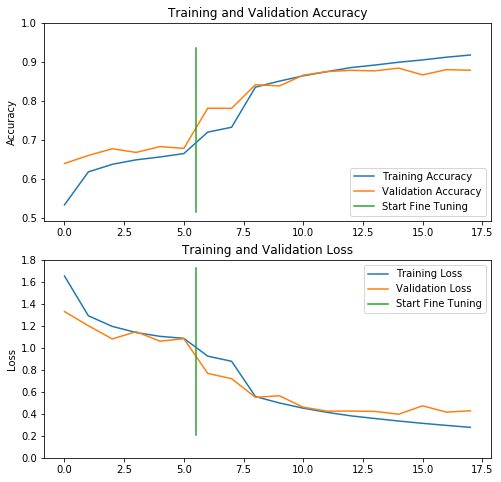

In [31]:
model_history(acc, loss, val_acc, val_loss)

### 模型測試

In [32]:
# 清除 keras graph
K.clear_session()

In [33]:
# 使用 custom_objects 加載有自定義方法的模型
model = keras.models.load_model(
    './keras_model/resnet_finetune.h5', custom_objects={'gelu': gelu}
)

In [34]:
# lables list
cifar10_name = ['airplain', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [35]:
def load_image(image_path):
    '''讀取 image 並進行預處理。
    
    Args:
      image_path: string. image 的路徑位置。
      
    Returns:
      img: 3D np.array. image 的 np.array，呈現圖像可以使用。
      img_arr: 4D np.array. 加入 bathc 的 image np.array，分析時使用。
    '''
    img = cv2.imread(image_path)[:,:,::-1]
    img_preprocess = resnet50.preprocess_input(img)
    img_resize = cv2.resize(img_preprocess, (224, 224), interpolation=cv2.INTER_CUBIC)
    img_arr = np.expand_dims(img_resize, axis=0)
    return img, img_arr
    

def prediction_image(image_path, model, label_list):
    '''預測圖像分類，並呈現 top-5 的類別和圖像照片。
    
    Args:
      image_path: string. image 的路徑位置。
      model: keras.models. 預測模型。
      label_list: list. 帶有 label name 的 list。
      
    Returns:
      None.
    '''
    img, img_arr = load_image(image_path)
    outcome = model.predict(img_arr)[0]
    outcome_sort = outcome.argsort()[::-1][:5]
    plt.imshow(img)
    for i in outcome_sort:
        print('{:.3f}  {}'.format(outcome[i], label_list[i]))
        
def feature_output(image_path, model, layers_name):
    '''取出某幾層的圖像特徵。
    
    Args:
      image_path: string. image 的路徑位置。
      model: keras.models. 預測模型。
      layers_name: list. 要取出的特徵層。
      
    Returns:
      None.
    '''
    img, img_arr = load_image(image_path)
    layers_output = [model.get_layer(layer).output for layer in layers_name]
    feature_model = keras.models.Model(inputs=[model.input], outputs=layers_output)
    return feature_model.predict(img_arr)

0.996  airplain
0.002  bird
0.001  deer
0.001  ship
0.000  truck


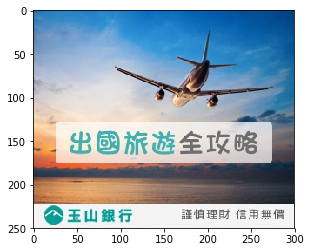

In [37]:
image_path =  './dataset/material/not_car/811fe7f6c41d29d5fcee63d11be4b29e.jpg'
prediction_image(image_path, model, cifar10_name)

### Reference

* [https://www.tensorflow.org/alpha/tutorials/images/transfer_learning](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning) - TensorFlow 官網教程
* [https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) - Keras Blog 教程
* [https://github.com/PrzemekPobrotyn/CIFAR-10-transfer-learning/blob/master/report.ipynb](https://github.com/PrzemekPobrotyn/CIFAR-10-transfer-learning/blob/master/report.ipynb) - 網路上 github 的教程，他提及了 keras resnet50 的 BN 層會存在問題。
* [http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken) - 清楚介紹 BN 層存在的問題以及提供補釘，雖然我沒有使用補釘。
* [https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/) - G. T. Wang 的教程
* [https://stackoverflow.com/questions/52282108/keras-accuracy-drops-while-finetuning-inception](https://stackoverflow.com/questions/52282108/keras-accuracy-drops-while-finetuning-inception) - `set_learning_phase` 的用法